# Comparison of Statistical Measures
Calculating statistical measures of distributions (mean, STD, kurtosis, etc.), and correlating them between human and GPT ratings of words. This was the original plan, simply to compare the shapes and qualities of the distributions.

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode, skew, kurtosis, entropy

In [72]:
# List of statistical measures
MEASURES = ['mean', 'median', 'std', 'skewness', 'kurtosis', 'entropy']

In [96]:
def safe_int_convert(string):
    """
    Convert a string to an integer, but return nan if it errors.
    """
    try:
        return int(float(string))
    except:
        return np.nan
    
def get_gpt_ratings(filename):
    """
    Take in the GPT ratings CSV (the cache file) and convert this into readable ratings.
    Safely convert strings to ints, drop nans, and ensure the ratings stay between 1 and 7.
    """
    gpt_ratings = pd.read_csv(filename)
    gpt_ratings["rating"] = gpt_ratings["rating"].apply(safe_int_convert)
    gpt_ratings = gpt_ratings.dropna()
    gpt_ratings["rating"] = np.clip(gpt_ratings["rating"], 1, 7)
    return gpt_ratings

def calculate_entropy(x):
    value_counts = np.bincount(x)
    probabilities = value_counts / len(x)
    return entropy(probabilities, base=2)

def get_statistics(ratings):
    """
    Gather a df of statistical measures using the original ratings dfs.
    """
    statistics = ratings.groupby('word')['rating'].agg(
        count='count',
        mean='mean',
        median='median',
        std='std',
        skewness=lambda x: skew(x, bias=False),
        kurtosis=lambda x: kurtosis(x, bias=False),
        entropy=lambda x: calculate_entropy(x)
    )
    return statistics.reset_index()

def correlate(human_stats, gpt_stats, statistic):
    """
    Get pearson's r for a given statistic.
    """
    return human_stats[statistic].corr(gpt_stats[statistic])

def get_human_ratings(filename):
    """
    Collect human ratings using the CSV filename.
    """
    human_ratings = pd.read_csv(filename)
    human_ratings = human_ratings[['word', 'Response']]
    human_ratings.columns = ['word', 'rating']
    wordlist = human_ratings['word'].unique()
    wordlist = wordlist[wordlist != "This is a test; click 1."]
    human_ratings = human_ratings[human_ratings['word'].isin(wordlist)]
    return human_ratings

def correlate_dimension(human_filename, gpt_filename):
    """
    For a semantic dimension (i.e. valence or concreteness), get human and GPT ratings, 
    get their statistical measures, collect the correlations, and return these data.
    """
    
    human_ratings = get_human_ratings(human_filename)
    human_stats = get_statistics(human_ratings)
    
    gpt_ratings = get_gpt_ratings(gpt_filename)
    gpt_stats = get_statistics(gpt_ratings)
    
    correlations = {measure: correlate(human_stats, gpt_stats, measure) for measure in MEASURES}
    correlations = pd.DataFrame([correlations]).T
    correlations.columns = ['correlation']
    return human_stats, gpt_stats, correlations

In [106]:
human_stats, gpt_stats, correlations = correlate_dimension('glasgow_valence.csv', 'gpt_valence_ratings.csv')
correlations

/var/folders/4k/z019px4j0t7csyx6sb1stb_m0000gn/T/ipykernel_98721/2794909084.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness=lambda x: skew(x, bias=False),
/var/folders/4k/z019px4j0t7csyx6sb1stb_m0000gn/T/ipykernel_98721/2794909084.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis=lambda x: kurtosis(x, bias=False),


,correlation
mean,0.601800
median,0.592164
std,0.112249
skewness,0.045608
kurtosis,-0.047126
entropy,0.119145


Quick note: It looks like the skewness and kurtosis measures are unreliable, probably because the GPT data has too much "consensus" and spikes heavily at a single number. The likert scale of 1-7 is probably too low-resolution as well.

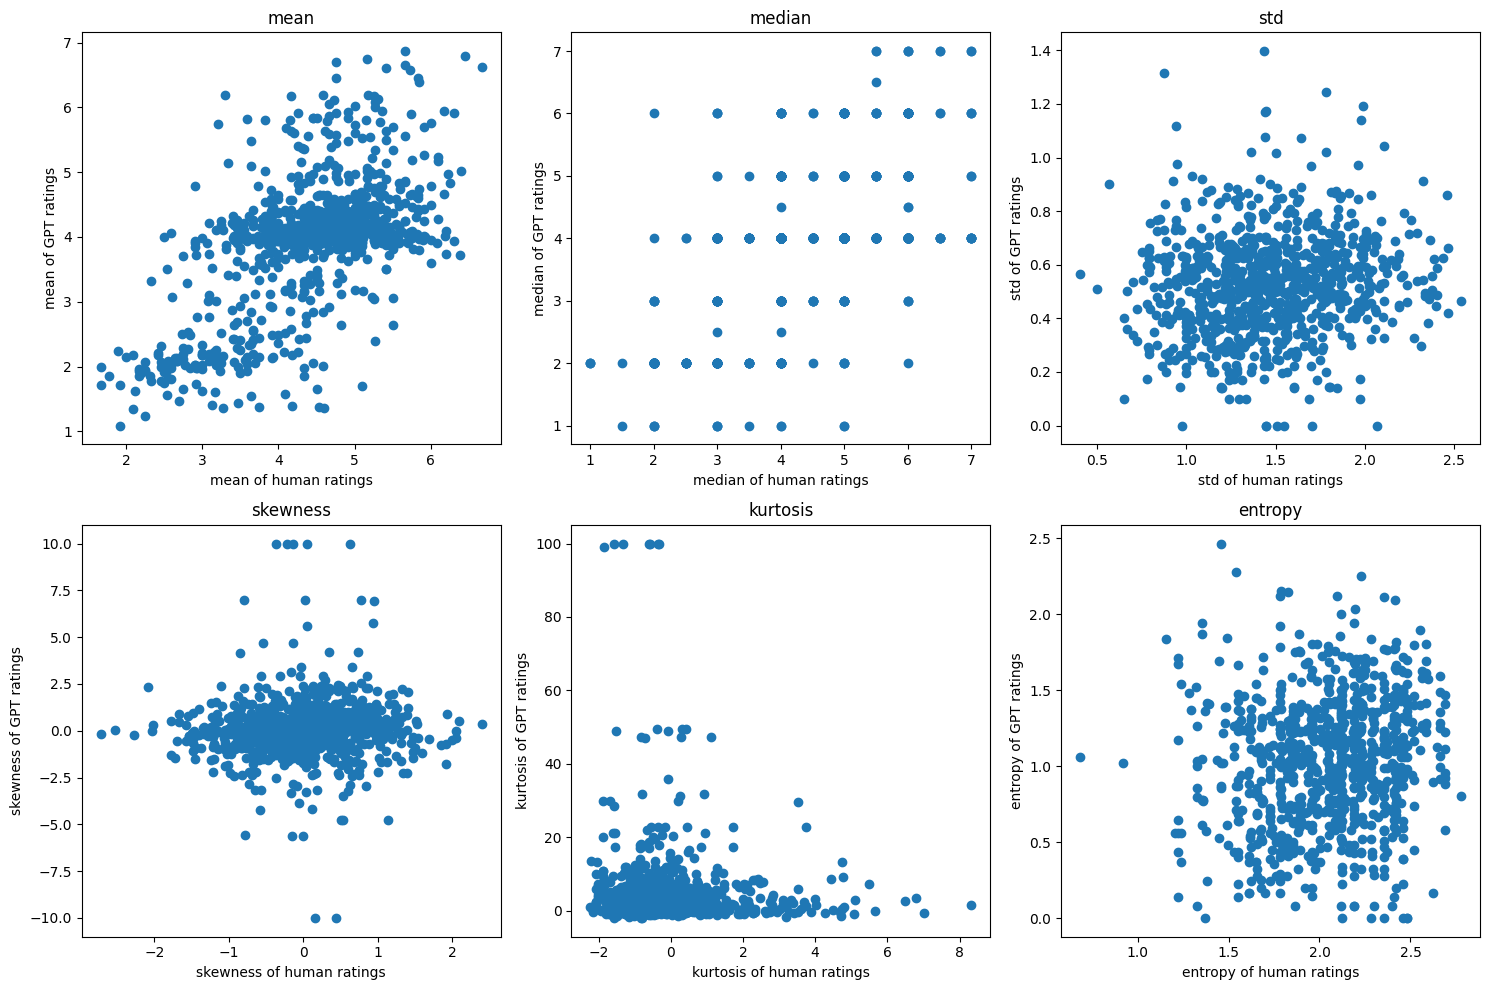

In [107]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, measure in enumerate(MEASURES):
    row, col = divmod(i, 3)
    axes[row, col].scatter(human_stats[measure], gpt_stats[measure])
    axes[row, col].set_xlabel(f'{measure} of human ratings')
    axes[row, col].set_ylabel(f'{measure} of GPT ratings')
    axes[row, col].set_title(measure)

plt.tight_layout()
plt.show()


It does seem like the only measures that correlate are mean and median. STD correlates weakly, but this might not mean anything significant.

I've tried this with both valence and concreteness, at temperatures 1.0, 1.2, and 1.5, and none of these have very different results. The only thing worth pointing out is that the correlation of mean seems to go down at temp=1.5, probably because there is less predictability.